## Day 2 Task: Creating a map from data.

This task is to teach you how to bring data from a satellite file and locate it on a map of the Earth. Much of the heavy lifting here is done within the basemap or cartopy libraries (see notebooks/cartopyGuide.ipynb for examples). But working with geospatial data invariably means you need to show where the data exists on a map.

In [1]:
# Libraries used

import numpy as np
import netCDF4 as nc4
from netCDF4 import Dataset

### Reading a NetCDF file

This will be similar to what we did earlier with HDF files. Our example file today comes from the TROPOMI instrument.

In [2]:

my_example_nc_file = 'S5P_OFFL_L2__NO2____20220116T180124_20220116T194254_22081_02_020301_20220118T102523.nc'
fh = Dataset(my_example_nc_file, mode='r')
print (fh)


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7
    institution: KNMI
    source: Sentinel 5 precursor, TROPOMI, space-borne remote sensing, L2
    summary: TROPOMI/S5P NO2 1-Orbit L2 Swath 5.5x3.5km
    tracking_id: 5ddc3f35-391a-4e6b-ab97-5c444c8cef52
    id: S5P_OFFL_L2__NO2____20220116T180124_20220116T194254_22081_02_020301_20220118T102523
    time_reference: 2022-01-16T00:00:00Z
    time_reference_days_since_1950: 26313
    time_reference_julian_day: 2459595.5
    time_reference_seconds_since_1970: 1642291200
    time_coverage_start: 2022-01-16T18:22:59Z
    time_coverage_end: 2022-01-16T19:21:22Z
    time_coverage_duration: PT3503.562S
    time_coverage_resolution: PT0.840S
    orbit: 22081
    references: http://www.tropomi.eu/data-products/nitrogen-dioxide https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-5p/products-algorithms
    processor_version: 2.3.1
    keywords_vocabulary: AGU index terms

### Getting groups and subgroups in NetCDF

The print statement above will have produced a long set of attributes containing information about the file (when it was created, what version of the algorithm was used, ...). But we want to get some data! Let's look at the top-level groups and one level beneath that. The output is slightly different from what we saw with the HDF example, but it is close enough that you should get the general idea.

In [3]:
print (fh.groups)

print (fh.groups['PRODUCT'])


{'PRODUCT': <class 'netCDF4._netCDF4.Group'>
group /PRODUCT:
    dimensions(sizes): scanline(4172), ground_pixel(450), corner(4), time(1), polynomial_exponents(6), intensity_offset_polynomial_exponents(1), layer(34), vertices(2)
    variables(dimensions): int32 scanline(scanline), int32 ground_pixel(ground_pixel), int32 time(time), int32 corner(corner), int32 polynomial_exponents(polynomial_exponents), int32 intensity_offset_polynomial_exponents(intensity_offset_polynomial_exponents), int32 layer(layer), int32 vertices(vertices), float32 latitude(time, scanline, ground_pixel), float32 longitude(time, scanline, ground_pixel), int32 delta_time(time, scanline), <class 'str'> time_utc(time, scanline), uint8 qa_value(time, scanline, ground_pixel), float32 nitrogendioxide_tropospheric_column(time, scanline, ground_pixel), float32 nitrogendioxide_tropospheric_column_precision(time, scanline, ground_pixel), float32 nitrogendioxide_tropospheric_column_precision_kernel(time, scanline, ground_pix

### Finding the data values needed to make a map

If we want a simple map, we probably want to know where our data is located (its latitude and longitude), and then some data values to put into the map (we will use "nitrogendioxide_tropospheric_column" as an example). First we will list out the names of the variables contained in our "PRODUCT" group, then select the ones we would like and read them into our code.

In [4]:
print (fh.groups['PRODUCT'].variables.keys())

#By printing the .variables.keys() we can see that this .nc file has the following variables:

dict_keys(['scanline', 'ground_pixel', 'time', 'corner', 'polynomial_exponents', 'intensity_offset_polynomial_exponents', 'layer', 'vertices', 'latitude', 'longitude', 'delta_time', 'time_utc', 'qa_value', 'nitrogendioxide_tropospheric_column', 'nitrogendioxide_tropospheric_column_precision', 'nitrogendioxide_tropospheric_column_precision_kernel', 'averaging_kernel', 'air_mass_factor_troposphere', 'air_mass_factor_total', 'tm5_tropopause_layer_index', 'tm5_constant_a', 'tm5_constant_b'])


In [5]:
# If we select one of these variables, say the ‘nitrogendioxide_tropospheric_column’ using this command

print (fh.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column'])

# we can see attributes about this variable

<class 'netCDF4._netCDF4.Variable'>
float32 nitrogendioxide_tropospheric_column(time, scanline, ground_pixel)
    units: mol m-2
    standard_name: troposphere_mole_content_of_nitrogen_dioxide
    long_name: Tropospheric vertical column of nitrogen dioxide
    coordinates: longitude latitude
    ancillary_variables: nitrogendioxide_tropospheric_column_precision air_mass_factor_troposphere air_mass_factor_total averaging_kernel
    multiplication_factor_to_convert_to_molecules_percm2: 6.02214e+19
    _FillValue: 9.96921e+36
path = /PRODUCT
unlimited dimensions: 
current shape = (1, 4172, 450)
filling on


In [10]:
# NetCDF variables read in directly as numpy arrays, which we can slice as usual
# We select the 0 index in the first dimension because we only want the first "time" element
# (there is only one of these anyhow!)

lons = fh.groups['PRODUCT'].variables['longitude'][0,:,:]
lats = fh.groups['PRODUCT'].variables['latitude'][0,:,:]
no2 = fh.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column'][0,:,:]

# All our arrays should have the same shape at this point

print (lons.shape)
print (lats.shape)
print (no2.shape)

(4172, 450)
(4172, 450)
(4172, 450)


In [7]:
no2_units = fh.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column'].units
# this line gets the units of NO2 so we can add it to the plot later on
print (no2_units)

mol m-2


### Let's make a map!

Now we can create an instance of our map and start to plot things on it. The mapping library (cartopy) has many features that can be added here, including colorbars, gridlines, geographical features like country borders, and more.

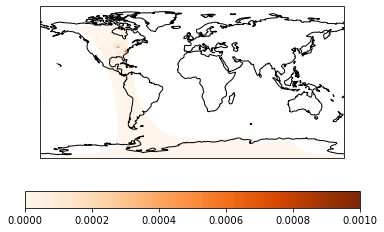

In [12]:
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt

fig = plt.figure()

ax = plt.axes(projection=ccrs.PlateCarree())

cmap = mpl.cm.Oranges
norm = mpl.colors.Normalize(vmin=0, vmax=0.001)

# note that we transform our data with the same projection as we are plotting
mesh = plt.pcolormesh(lons, lats, no2, shading='nearest', cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# Add a colorbar for the mesh
fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), orientation='horizontal')

ax.coastlines()

#ax.set_extent([-120, -70, 20, 50])

plt.show()


## Try it yourself!

#### 1. Open the example NetCDF file, or download your own from search.earthdata.nasa.gov

    The example file is similar to the dataset called "Sentinel-5P TROPOMI Tropospheric NO2 1-Orbit L2 5.5km x 3.5km V2 (S5P_L2__NO2____HiR) at GES DISC"

#### 2. Read the variables in your file and list them

    The TROPOMI files contain many more datasets than the VIIRS files we saw earlier. This is partly because sensing the amount of gas in the atmosphere is a more complicated process than measuring the radiance at the surface. Explore different groups within the file. Can you find the dataset for water vapour slant column density?

#### 3. Make a global map of "water_slant_column_density"

    This is an intermediate step in getting the NO2 amount, but it is still an interesting thing to map. In the example above, we used set_extent() to clip the map axis to a specific latitude/longitude region. We also sliced the data, taking only scanlines 3000 to 3500. Try reading in all of the water column data and all of the latitude/longitude data, and plotting in on a global map. Does the satellite actually see more over the poles? Can you find a map projection that proves this is not the case?
    
#### 4. Make a regional map of nitrogen dioxide

    Let's go back to the tropospheric vertical column of nitrogen dioxide ("nitrogendioxide_tropospheric_column"). What does this data look like over Alberta? Zoom your map way in to the point where you can see individual pixels (each is about 5.5 by 3.5 km). Try overlaying some map features (e.g. provincial borders, roads, rivers) to give your data some regional context.

    What happens to the map over Alberta if you screen out data with a quality flag ("qa_value") less than 0.5?
    
    What if you plot the ratio of the signal ("nitrogendioxide_tropospheric_column") to its precision ("nitrogendioxide_tropospheric_column_precision")?
    
    Can you make a map where you use the latitude/longitude boundaries of each ground pixel instead of the latitude/longitude of the pixel centre?



(4172, 450)


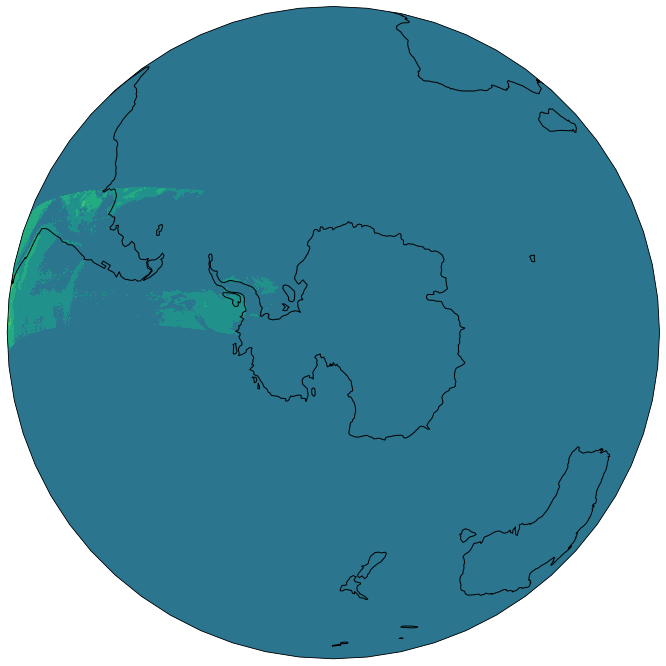

In [143]:

prodgroup = fh.groups['PRODUCT']
suppgroup = prodgroup.groups['SUPPORT_DATA']
detailgroup = suppgroup.groups['DETAILED_RESULTS']
#print(detailgroup)
watercol = detailgroup.variables['water_slant_column_density'][0,:,:]
print(watercol.shape)
mylons = fh.groups['PRODUCT'].variables['longitude'][0,:,:]
mylats = fh.groups['PRODUCT'].variables['latitude'][0,:,:]

dataproj = ccrs.PlateCarree()
mapproj = ccrs.Orthographic(central_latitude=-90)

fig3 = plt.figure(figsize=(12,12))
ax3 = plt.axes(projection=mapproj)

#cmap = mpl.cm.Oranges
#norm = mpl.colors.Normalize(vmin=0, vmax=0.001)
ax3.set_global()

# note that we transform our data with the same projection as we are plotting
#mesh = plt.contourf(lons, lats, watercol, cmap=cmap, transform=ccrs.Orthographic(central_latitude=-90))

ax3.contourf(mylons,mylats,watercol,transform=dataproj)
ax3.coastlines()

# Add a colorbar for the mesh
#fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap), orientation='horizontal')


plt.show()


/opt/anaconda3/envs/GEODACenv/lib/python3.9/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


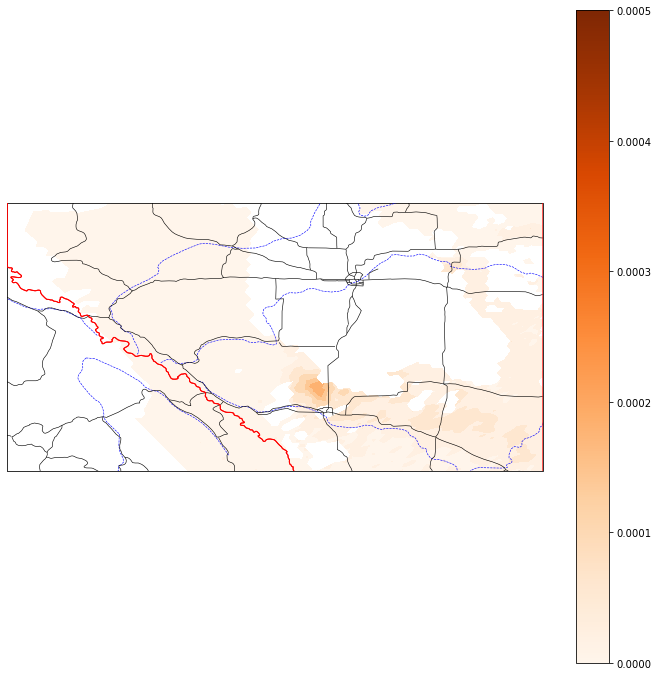

In [141]:
import cartopy.feature

#cartopy.config['pre_existing_data_dir'] = '/Users/thomaswalker/Documents/Research/Data/naturalearth/'

no2 = fh.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column'][0,:,:]
no2prec = fh.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column_precision'][0,:,:]
qaval = fh.groups['PRODUCT'].variables['qa_value'][0,:,:]
no2[qaval<0.5]=np.nan
ratio = np.divide(no2,no2prec)

fig2 = plt.figure(figsize=(12,12))
ax2=plt.axes(projection=ccrs.PlateCarree())

cmap = mpl.cm.Oranges
norm = mpl.colors.Normalize(vmin=0, vmax=0.0005)

ax2.coastlines()
rivers = cartopy.feature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', \
    scale='50m', edgecolor='b', facecolor='none')
roads = cartopy.feature.NaturalEarthFeature('physical', 'roads', scale='10m', edgecolor='k', facecolor='none')
provs = cartopy.feature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', scale='10m', edgecolor='r', facecolor='none')
ax2.add_feature(rivers, linestyle='--', linewidth=0.6, edgecolor="b", zorder=10)
ax2.add_feature(roads, linestyle='-', linewidth=0.6, edgecolor="k", zorder=10)
ax2.add_feature(provs, linestyle='-', linewidth=1.0, edgecolor="r", zorder=10)
result = ax2.contourf(lons,lats,no2,24,cmap=cmap,norm=norm)
ax2.set_extent([-120,-110,50,55])
fig2.colorbar(mpl.cm.ScalarMappable(cmap=cmap,norm=norm))
plt.show()


(300, 450, 4)


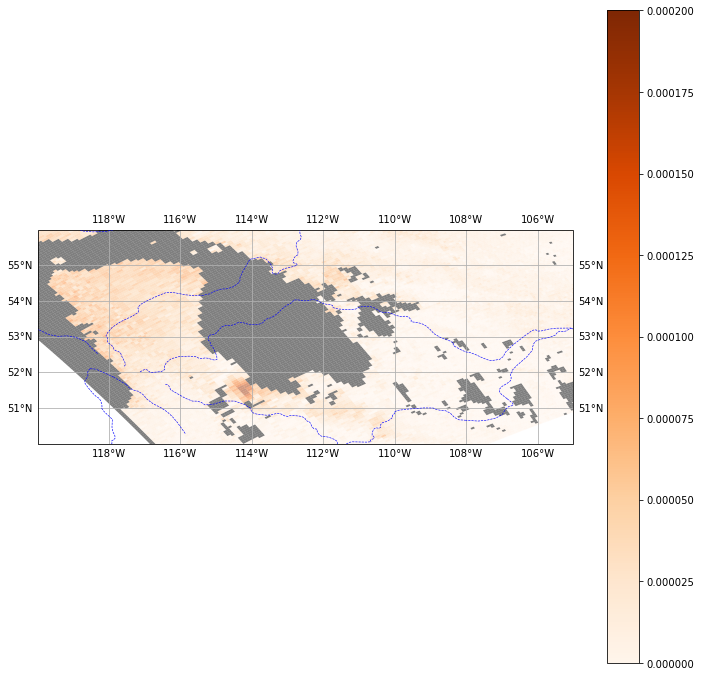

In [142]:
from shapely.geometry.polygon import Polygon

suppgroup = prodgroup.groups['SUPPORT_DATA']
#print(suppgroup)
geolgroup = suppgroup.groups['GEOLOCATIONS']
#print(geolgroup)
alongtrackcut = (3550, 3850)
latbds = geolgroup.variables['latitude_bounds'][0,alongtrackcut[0]:alongtrackcut[1],:,:]
lonbds = geolgroup.variables['longitude_bounds'][0,alongtrackcut[0]:alongtrackcut[1],:,:]
no2cut = fh.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column'][0,alongtrackcut[0]:alongtrackcut[1],:]
qavcut = fh.groups['PRODUCT'].variables['qa_value'][0,alongtrackcut[0]:alongtrackcut[1],:]
no2cut[qavcut<0.5]=np.nan;
print(latbds.shape)
mylons = fh.groups['PRODUCT'].variables['longitude'][0,alongtrackcut[0]:alongtrackcut[1],:]
mylats = fh.groups['PRODUCT'].variables['latitude'][0,alongtrackcut[0]:alongtrackcut[1],:]

fig4 = plt.figure(figsize=(12,12))
ax4=plt.axes(projection=ccrs.PlateCarree())
cmap = mpl.cm.Oranges
vmin = 0
vmax = 0.0002
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
ax4.add_feature(rivers, linestyle='--', linewidth=0.6, edgecolor="b", zorder=10)

patches = []
facecolors = []

for i in range(latbds.shape[0]):
    for j in range(latbds.shape[1]):
#for i in range(10):
#    for j in range(10):
        thiscornerlats = latbds[i,j,:]
        thiscornerlons = lonbds[i,j,:]
        #print(thiscornerlats)
        #print(thiscornerlons)
        # reorder because Polygon wants points given clockwise (they are stored CCW)
        # include lower left corner twice to make a bounded polygon (return to the starting point)
        pgon = Polygon(((thiscornerlons[0],thiscornerlats[0]),
                        (thiscornerlons[3],thiscornerlats[3]),
                        (thiscornerlons[2],thiscornerlats[2]),
                        (thiscornerlons[1],thiscornerlats[1]),
                        (thiscornerlons[0],thiscornerlats[0])))
        #patches.append(pgon)
        #facecolors.append(cmap(no2cut[i,j])
        normedno2 = np.abs(no2cut[i,j])/(vmax - vmin)
        fcolor = cmap(normedno2)
        #print(no2cut[i,j])
        #print(normedno2)
        #print(fcolor)
        ax4.add_geometries([pgon],crs=ccrs.PlateCarree(),facecolor=fcolor,alpha=0.5)
#        ax4.add_geometries([pgon],crs=ccrs.PlateCarree(),facecolor='b',cmap=cmap,norm=norm)
#        ax4.add_geometries([pgon],crs=ccrs.PlateCarree(),facecolor='r',alpha=0.5)

#facecolors = cmap(facecolors)
#filledpgon = mpl.collections.PatchCollection(patches,facecolor=facecolors,cmap=cmap,norm=norm)
#ax4.add_collection(filledpgon)

ax4.set_extent([-120,-105,50,56])
ax4.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
fig4.colorbar(mpl.cm.ScalarMappable(cmap=cmap,norm=norm))
plt.show()
